<a href="https://colab.research.google.com/github/rylan-berry/DeepLearningIndependentStudy/blob/main/RegularizationLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Making Regularization Algorithms from Scratch

##Data Download

In [28]:
!git clone "https://github.com/rylan-berry/DeepLearningIndependentStudy.git"

fatal: destination path 'DeepLearningIndependentStudy' already exists and is not an empty directory.


In [29]:
import pandas as pd
import numpy as np

In [30]:
train_data = pd.read_csv("DeepLearningIndependentStudy/mnist_train.csv", header=None)
y_train = train_data[0].to_numpy()
x_train = train_data.drop(0, axis=1).to_numpy() / 255.0 #converts the inputs from 0-255 to 0-1, normalizing inputs

In [31]:
#sample input
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [32]:
val_data = pd.read_csv("DeepLearningIndependentStudy/mnist_test.csv", header=None)
y_val = val_data[0].to_numpy()
x_val = val_data.drop(0, axis=1).to_numpy()/255.0 #converts the inputs from 0-255 to 0-1, normalizing inputs

In [33]:
# Code produced by gemini
# Define the number of classes (0-9 for MNIST)
num_classes = 10

# Convert y_train to one-hot encoding
y_train = np.eye(num_classes)[y_train.astype(int)]

# Convert y_val to one-hot encoding
y_val = np.eye(num_classes)[y_val.astype(int)]

print("y_train after one-hot encoding (first 5 samples):")
print(y_train[:5])
print("\ny_val after one-hot encoding (first 5 samples):")
print(y_val[:5])


y_train after one-hot encoding (first 5 samples):
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

y_val after one-hot encoding (first 5 samples):
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [34]:
y_train.shape, x_train.shape

((60000, 10), (60000, 784))

##Model Structuring

###Auto Gradient

In [35]:
class Values:
  def __init__(self, vals, grads = True):
    self.vals = np.array(vals)
    self._backward = lambda: None
    self.grad = np.zeros_like(vals)
    self.grad_flag = grads

  #Gemini code that handles wierd broadcasting errors
  @staticmethod
  def _broadcast_grad(grad_from_output, original_shape):
    """
    Adjusts the gradient by summing over broadcasted dimensions to match the original shape.
    Assumes `grad_from_output` has the shape of the broadcasted result.
    `original_shape` is the shape of the tensor *before* broadcasting.
    """
    if grad_from_output.shape == original_shape:
        return grad_from_output

    # If original was a scalar, sum all dimensions of the gradient
    if original_shape == (): # scalar
        return np.sum(grad_from_output)

    # Identify axes where original_shape has size 1 and grad_from_output has size > 1
    axes_to_sum = []

    # Handle cases where original_shape might have fewer dimensions than grad_from_output
    # e.g., (D,) broadcast to (N, D). original_shape is padded implicitly with 1s on the left.
    diff_ndim = grad_from_output.ndim - len(original_shape)
    padded_original_shape = (1,) * diff_ndim + original_shape

    for i in range(grad_from_output.ndim):
        if padded_original_shape[i] == 1 and grad_from_output.shape[i] > 1:
            axes_to_sum.append(i)

    if axes_to_sum:
        return np.sum(grad_from_output, axis=tuple(axes_to_sum), keepdims=True)

    return grad_from_output # No broadcasting to sum over, or complex broadcasting not handled by this simple logic.

  def __repr__(self):
    return "vals: " + self.vals.__repr__() + "\ngrads: "+ self.grad.__repr__()

  def __add__(self, other):
    other = other if isinstance(other, Values) else Values(other) #Let's say a non-Values is passed into this, then we sould make it Values

    out = Values(self.vals + other.vals)
    def backward():
      if self.grad_flag:
        self_grad_to_add = Values._broadcast_grad(out.grad, self.vals.shape)
        self.grad = self.grad + self_grad_to_add
        self._backward()
      if other.grad_flag:
        other_grad_to_add = Values._broadcast_grad(out.grad, other.vals.shape)
        other.grad = other.grad + other_grad_to_add
        other._backward()

    out._backward = backward
    return out
  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return other + (-self)

  def __mul__(self, other):
    other = other if isinstance(other, Values) else Values(other)

    out = Values(self.vals * other.vals)
    def backward():
      if self.grad_flag:
        # Gradient for self is `other.vals * out.grad`
        grad_term_for_self = other.vals * out.grad
        self.grad =self.grad + Values._broadcast_grad(grad_term_for_self, self.vals.shape)
      if other.grad_flag:
        # Gradient for other is `self.vals * out.grad`
        grad_term_for_other = self.vals * out.grad
        other.grad =other.grad + Values._broadcast_grad(grad_term_for_other, other.vals.shape)
        other._backward()
      if self.grad_flag:
        self._backward()

    out._backward = backward
    return out

  def __rmul__(self, other): #other * self
    return self * other

  def __matmul__(self, other):
    other = other if isinstance(other, Values) else Values(other)
    out = Values(self.vals @ other.vals)
    def backward():
      if self.grad_flag:
        # out.grad @ other.vals.T matches self.vals shape, so no broadcast_grad needed here.
        self.grad = self.grad + out.grad @ other.vals.T
      if other.grad_flag:
        # self.vals.T @ out.grad matches other.vals shape, so no broadcast_grad needed here.
        other.grad = other.grad + self.vals.T @ out.grad
        other._backward()
      if self.grad_flag:
        self._backward()
    out._backward = backward
    return out

  def __rmatmul__(self, other):
    return Values(other) @ self

  def exp(self):
    out = Values(np.exp(self.vals))
    def backward():
      if self.grad_flag:
        grad_term = out.vals * out.grad
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Values(self.vals**other)
    def backward():
      if self.grad_flag:
        grad_term = other * (self.vals**(other - 1)) * out.grad
        self.grad =self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def log(self):
    out = Values(np.log(self.vals))
    def backward():
      if self.grad_flag:
        grad_term = self.vals**-1 *out.grad
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def relu(self):
    out = Values(np.maximum(0,self.vals))
    def backward():
      if self.grad_flag:
        grad_term = out.grad * (self.vals > 0)
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def mean(self):
    out = Values(np.mean(self.vals))
    def backward():
      if self.grad_flag:
        # For mean, out.grad is a scalar. Adding a scalar to self.grad (an array)
        # implicitly broadcasts the scalar across all elements, which is the correct behavior
        # for the gradient of a mean operation.
        self.grad = self.grad + (out.grad / self.vals.size)
        self._backward()
    out._backward = backward
    return out

  def __call__(self):
    return self

  def __getitem__(self, item):
    out = Values(self.vals[item])
    saved_item = item
    def backward():
        if self.grad_flag:
            temp_grad = np.zeros_like(self.vals)
            temp_grad[saved_item] = out.grad
            self.grad = self.grad + temp_grad
            self._backward()
    out._backward = backward
    return out

  def backward(self):
    self.grad = np.ones_like(self.vals)
    self._backward()

  def __getattr__(self, name):
    if name == "_":
      return self
    if name == "T" or name == "transpose":
      out = Values(self.vals.T)
      def backward():
        if self.grad_flag:
          # out.grad is the shape of out.vals (transposed vals), so out.grad.T is the shape of self.vals.
          # No broadcast_grad needed here.
          self.grad = self.grad + out.grad.T
          self._backward()
      out._backward = backward
      return out

    if hasattr(self.vals, name) and not callable(getattr(self.vals, name)):
        return getattr(self.vals, name)

    raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}' or attribute is not supported for automatic differentiation")

####Migrating Data to Values

In [36]:
x_train = Values(x_train)
y_train = Values(y_train)
x_val = Values(x_val)
y_val = Values(y_val)

###Sequence

In [37]:
class Sequence:
  def __init__(self, arr):
    self.arr = arr

  def __call__(self, x):
    x_i = x
    for item in self.arr:
      x_i = item(x_i)
    return x_i

  def params(self):
    weis = []
    biases = []
    for l in self.arr:
      w, b = l.params()
      weis.append(w)
      biases.append(b)

    return weis, biases

  def updateParams(self, l_rate):
    for l in self.arr:
      l.updateParams(l_rate)

##Layer

In [38]:
class Layer:
  def __init__(self, input,out,activ="_",rangeW=(-1,1),rangeB=(-1,1)):
    self.weights = Values((rangeW[0]-rangeW[1])*np.random.rand(input,out)+rangeW[1])
    self.bias = Values((rangeB[0]-rangeB[1])*np.random.rand(1,out)+rangeB[1])
    self.activation = activ

  def __call__(self, x):
    y = x @ self.weights + self.bias
    return getattr(y, self.activation, y)()

  def params(self):
    return self.weights, self.bias

  def updateParams(self, l_rate):
    self.weights.vals = self.weights.vals - l_rate * self.weights.grad
    self.bias.vals = self.bias.vals - l_rate * self.bias.grad
    self.weights.grad = self.weights.grad * 0
    self.bias.grad = self.bias.grad * 0



##Network Block (Dense)

In [39]:
class Dense:
  def __init__(self, layNum, inL, midL, outL, activ="_",f_activ="_",rangeW=(-1,1),rangeB=(-1,1)):
    if layNum < 1:
      print("Dense can't have 0 layers or below.")
    elif layNum == 1:
      self.seq = Sequence([Layer(inL,outL,f_activ,rangeW,rangeB)])
    else:
      lays = []
      for i in range(layNum):
        if i == 0:
          lays.append(Layer(inL,midL,activ,rangeW,rangeB))
        elif i == layNum-1:
          lays.append(Layer(midL,outL,f_activ,rangeW,rangeB))
        else:
          lays.append(Layer(midL,midL,activ,rangeW,rangeB))
      self.seq = Sequence(lays)

  def __call__(self, x):
      return self.seq(x)

  def params(self):
      return self.seq.params()
  def updateParams(self, l_rate):
    self.seq.updateParams(l_rate)


##Dropout

In [40]:
class Dropout:
  def __init__(self, size, chance):
    self.size = size
    self.rate = chance
    self.inTrain = False

  def __call__(self, x):
    r = self.rate
    if r <= 0.0 or not self.inTrain:
      return x
    elif r >= 1.0:
      return Values(np.zeros_like(x.vals))

    do = Values(np.random.choice([0,1/(1-r)],size=(self.size,),p=[r, 1-r]))
    return x * do

  def updateParams(self, l_rate): #here so errors don't occur when update params is called for the whole sequence
    return



##Model Class

In [44]:
class Model:
  def __init__(self, blocks, regu = "", train = True):
    self.blocks = Sequence(blocks)
    self.regu = regu
    self.inTraining = train
    self.train_loss = []
    self.val_loss = []

  def __call__(self, x):
    return self.blocks(x)

  def train(self, epochs, x_t, y_t, x_v, y_v, val_run=1, l_rate=0.01, batch_size = None):
    x_train = x_t if isinstance(x_t, Values) else Values(x_t)
    y_train = y_t if isinstance(y_t, Values) else Values(y_t)
    x_val = x_v if isinstance(x_v, Values) else Values(x_v)
    y_val = y_v if isinstance(y_v, Values) else Values(y_v)

    for l in self.blocks.arr:
      if isinstance(l, Dropout):
        l.inTrain = True

    if not batch_size:
      batch_size = len(x_train.vals)

    batches = 0
    if len(x_train.vals) % batch_size == 0:
      batches = int(len(x_train.vals) / batch_size)
    else:
      batches = int(len(x_train.vals) / batch_size + 1)

    loss_strt = len(self.train_loss)
    for i in range(epochs):
      for b in range(batches):
        print(f"\rep{i}: b{b}/{batches}", end="")
        y_hat = self.__call__(x_train[b*batch_size:(b+1)*batch_size])
        mse_loss = ((y_train[b*batch_size:(b+1)*batch_size] - y_hat)**2).mean()
        self.train_loss.append((loss_strt+i,mse_loss.vals))
        mse_loss.grad = np.ones_like(mse_loss.vals)
        mse_loss.backward()
        self.blocks.updateParams(l_rate)
      print("\r", end="")

      if i % val_run == 0:
          y_val_hat = self.__call__(x_val)
          val_loss = ((y_val - y_val_hat)**2).mean().vals
          print(f"epoch: {i} \t mse loss: {val_loss}")
          self.val_loss.append((loss_strt+i,val_loss))

    for l in self.blocks.arr:
      if isinstance(l, Dropout):
        l.inTrain = False

##XOR Lab Test
Makes sure framework works

In [45]:
x = Values(np.array([[0,0],[0,1],[1,0],[1,1]],dtype='f'))
y = Values(np.array([[0],[1],[1],[0]],dtype='f'))

In [48]:
m = Model([Dense(2,2,8,1,activ="relu",f_activ="relu")])
m.train(20, x,y,x,y,val_run=4, l_rate=0.1)
m(x)

epoch: 0 	 mse loss: 0.5031075197242023
epoch: 4 	 mse loss: 0.5007715460367345
epoch: 8 	 mse loss: 0.5001905314160442
epoch: 12 	 mse loss: 0.500046911283788
epoch: 16 	 mse loss: 0.5000115322420056


vals: array([[0.00401197],
       [0.        ],
       [0.        ],
       [0.        ]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])

In [49]:
m.train(20, x,y,x,y, l_rate=0.1)
m(x)

epoch: 0 	 mse loss: 0.5000028327477255
epoch: 1 	 mse loss: 0.5000019941151427
epoch: 2 	 mse loss: 0.5000014037309614
epoch: 3 	 mse loss: 0.5000009881212308
epoch: 4 	 mse loss: 0.5000006955533619
epoch: 5 	 mse loss: 0.5000004896046468
epoch: 6 	 mse loss: 0.5000003446325447
epoch: 7 	 mse loss: 0.5000002425847048
epoch: 8 	 mse loss: 0.5000001707526676
epoch: 9 	 mse loss: 0.5000001201901905
epoch: 10 	 mse loss: 0.5000000845996184
epoch: 11 	 mse loss: 0.5000000595478361
epoch: 12 	 mse loss: 0.5000000419142843
epoch: 13 	 mse loss: 0.5000000295023665
epoch: 14 	 mse loss: 0.5000000207658921
epoch: 15 	 mse loss: 0.5000000146165016
epoch: 16 	 mse loss: 0.5000000102881084
epoch: 17 	 mse loss: 0.5000000072414743
epoch: 18 	 mse loss: 0.5000000050970388
epoch: 19 	 mse loss: 0.5000000035876364


vals: array([[0.00011979],
       [0.        ],
       [0.        ],
       [0.        ]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])

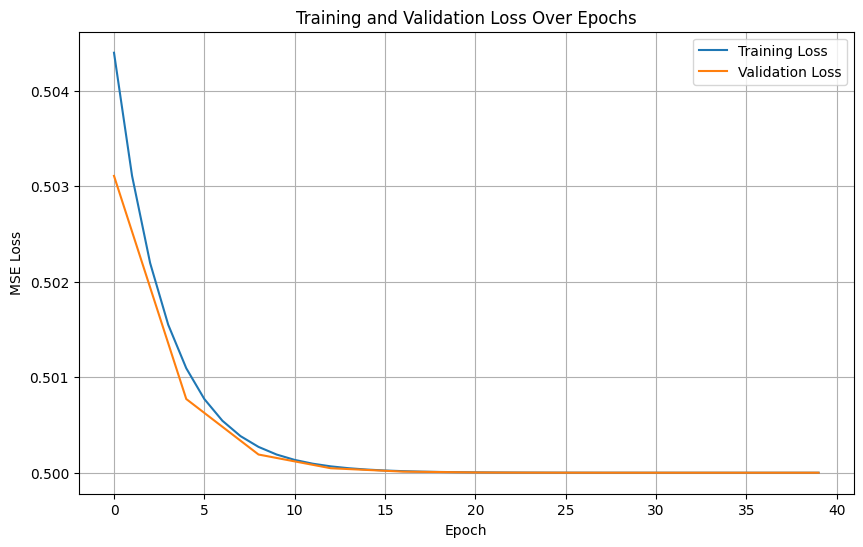

In [50]:
#Generated by Gemini
import matplotlib.pyplot as plt

# Extract training loss data
train_epochs = [item[0] for item in m.train_loss]
train_losses = [item[1] for item in m.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in m.val_loss]
val_losses = [item[1] for item in m.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##MNIST Basic Model

In [51]:
y_val.vals.shape

(10000, 10)

In [52]:
y_train.vals.shape

(60000, 10)

In [ ]:
nreg_model = Model([Dense(2,784,1024,512,activ="relu",f_activ="relu"),Dense(2,512,256,10,activ="relu")])
nreg_model.train(10, x_train[:5000],y_train[:5000],x_val[:500],y_val[:500],val_run=5, l_rate=0.01, batch_size=128)
nreg_model(x_val[:5]), y[:5]

ep0: b4/40

/tmp/ipython-input-1859279607.py:96: RuntimeWarning: overflow encountered in matmul
  out = Values(self.vals @ other.vals)
/tmp/ipython-input-1859279607.py:96: RuntimeWarning: invalid value encountered in matmul
  out = Values(self.vals @ other.vals)


epoch: 0 	 mse loss: nan
epoch: 5 	 mse loss: nan
ep8: b3/40

In [ ]:
# Extract training loss data
train_epochs = [item[0] for item in nreg_model.train_loss]
train_losses = [item[1] for item in nreg_model.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in nreg_model.val_loss]
val_losses = [item[1] for item in nreg_model.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
do_model = Model([Dense(2,784,1024,512,activ="relu"),Dropout(512,0.4),Dense(2,512,256,10,activ="relu")])
do_model.train(10, x_train[:5000],y_train[:5000],x_val[:500],y_val[:500],val_run=5, l_rate=0.01, batch_size=128)
do_model(x_val[:5]), y[:5]

##TODO LIST:
[X] Framework

[X] Add loss graph for train vs val

[X] Implement Batching

[X] No Reg MNIST Model

[X] Implement Dropout Layer

[X] Dropout MNIST Model -- Assuming no errors

[0] Implement L2 Norm

[0] L2 MNIST Model

[0] Both MNIST Model